<a href="https://colab.research.google.com/github/mnmahir/best-fyp/blob/main/System_web_app_(backend).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install anvil-uplink
import anvil.server
import anvil.media
# Google Drive
from google.colab import drive
# General
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
!pip install image_slicer
import os
import glob
import image_slicer
# Keras Library
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
# Others
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
model = tf.keras.models.load_model('/content/gdrive/MyDrive/FYP Stuff/Model/DenseNet201_All_Stain_Model.h5')

Mounted at /content/gdrive


In [3]:
###########################
# Initialization
###########################
IMAGE_CLASSES = ['NORMAL','GRADE 1','GRADE 2','GRADE 3']
IMAGE_WIDTH,IMAGE_HEIGHT = (224,224)
sliced_img_path = '/content/sliced_img'
try: 
  os.mkdir(sliced_img_path) # For before calling slice
except:
  print("Folder already created")



In [4]:
#####################################
# Slice image / remove sliced images
#####################################
#To be called before making prediction
def slice_image(ori_img, srow = 6, scol = 8): #later add row and col
  os.chdir(sliced_img_path)

  ori_img.save('ori.png')
  if scol > 1 or srow > 1:
    image_slicer.slice('ori.png', row = srow, col = scol)
    os.remove('ori.png') #Delete original image
  os.chdir('/content')

# To be called after done with prediction and calculation
def remove_sliced_images():
  files = glob.glob(sliced_img_path+'/*')  
  for f in files:
      os.remove(f)                      # Delete everything in folder

# Get slicing parameter (200px)
def get_slice_param(img):
  img_width, img_height = img.size
  swidth = int(img_width/200) #To get 200px
  sheight = int(img_height/200)
  owidth = int(img_width/swidth)
  oheight = int(img_height/sheight)
  return swidth, sheight, owidth, oheight

#####################################
# Make prediction (Will predict all images in the "sliced_img" folder)
#####################################
def get_predictions():
  predictions = []
  for i,img in enumerate(sorted(os.listdir(sliced_img_path))):
    img = os.path.join(sliced_img_path, img)
    img = image.load_img(img, target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255
    predictions.append(model.predict(arr))
  pred_labels = np.argmax(predictions, axis=-1)
  return predictions, pred_labels

############################
# Save all prediction patches
############################
def save_predicted_patches(predictions, pred_labels, srow = 6, scol = 8, conf_thrs = 0.8):
  imeg_freq = len(pred_labels)
  disp_row = srow
  plt.figure(1, figsize = (scol*1.9, srow*2.2))
  for j,img in enumerate(sorted(os.listdir(sliced_img_path))):
    img = image.load_img(os.path.join(sliced_img_path,img), target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    plt.subplot(srow, scol, j+1)
    if predictions[j][0,pred_labels[j][0]] < conf_thrs:
      title = "Low Confidence"
      plt.title(title, color = 'red', verticalalignment = 'top')
    else:
      title = str(IMAGE_CLASSES[pred_labels[j][0]]) + '\n' + str(round(predictions[j][0,pred_labels[j][0]],2))
      plt.title(title, verticalalignment = 'top')
    plt.axis('off')
    plt.imshow(img)

  #plt.show()
  plt.savefig('predicted_patches.png', bbox_inches='tight', pad_inches = 0)
############################
# Calculate frequency of class prediction
############################
def get_pred_freq(predictions, pred_labels, conf_thrs = 0.8):
  freq_class = [0,0,0,0]
  for j in range(len(pred_labels)):
    if predictions[j][0,pred_labels[j][0]] >= conf_thrs:
      freq_class[pred_labels[j][0]] += 1
  max_class = freq_class.index(max(freq_class))
  return freq_class, IMAGE_CLASSES[max_class]




In [5]:
anvil.server.connect("L3PK5MYQVJ4ZK5FTWKPZYKUD-FBM5VHPXV3N7HNS4")
@anvil.server.callable
def predict_click(img_file, conf_threshold):
  global image_received, score
  with anvil.media.TempFile(img_file) as filename:
    img = load_img(filename)
  image_received = img
  swidth, sheight, owidth, oheight = get_slice_param(img)
  slice_image(img, srow = sheight, scol = swidth)
  predictions, pred_labels = get_predictions()
  save_predicted_patches(predictions, pred_labels, srow = sheight, scol = swidth, conf_thrs = conf_threshold)
  class_freq, max_class = get_pred_freq(predictions, pred_labels, conf_thrs = conf_threshold)
  remove_sliced_images()

  send_image = anvil.media.from_file('predicted_patches.png', '/content/') #To convert into anvil media object (filename, path)
  return class_freq, max_class , send_image

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


# Debug Code

In [ ]:
def get_pred_freq(predictions, pred_labels, conf_thrs = 0.8):
  freq_class = [0,0,0,0]
  for j in range(len(pred_labels)):
    if predictions[j][0,pred_labels[j][0]] >= conf_thrs:
      freq_class[pred_labels[j][0]] += 1
  max_class = freq_class.index(max(freq_class))
  return freq_class, IMAGE_CLASSES[max_class]

In [ ]:
test,test2 = get_pred_freq(predictions, pred_labels)

In [ ]:
print(test,test2)

[0, 4, 0, 35] GRADE 3


In [ ]:
save_predicted_patches(predictions, pred_labels, srow = 6, scol = 8, conf_thrs = 0.5)

<Figure size 1094.4x950.4 with 0 Axes>

In [ ]:
print(image_received)

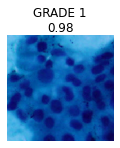

In [ ]:
slice_image(image_received, srow = 1, scol = 1)
predictions, pred_labels = get_predictions()
save_predicted_patches(predictions, pred_labels, srow = 1, scol = 1)

In [ ]:
remove_sliced_images()

In [ ]:
#testlist = np.ndarray.tolist(predictions)
print(predictions[0][0,1]) #[index][fixed,class]

0.12670526


In [ ]:
print(predictions)

[array([[2.4021899e-06, 9.8048341e-01, 1.9482939e-02, 3.1256408e-05]],
      dtype=float32), array([[9.2769420e-01, 2.0265233e-04, 1.2306024e-02, 5.9797186e-02]],
      dtype=float32), array([[9.5155984e-01, 5.0472486e-04, 2.5059439e-02, 2.2876056e-02]],
      dtype=float32), array([[0.0034586 , 0.01350763, 0.9285609 , 0.05447289]], dtype=float32), array([[0.5138149 , 0.00613647, 0.08659206, 0.39345652]], dtype=float32), array([[0.05954013, 0.00306718, 0.02044324, 0.9169494 ]], dtype=float32), array([[0.05829214, 0.00134238, 0.7761358 , 0.16422963]], dtype=float32), array([[0.16448376, 0.00307028, 0.6589897 , 0.1734562 ]], dtype=float32), array([[0.00336201, 0.00140475, 0.94969773, 0.04553559]], dtype=float32), array([[9.5178354e-01, 2.2722952e-05, 6.3745850e-03, 4.1819129e-02]],
      dtype=float32), array([[0.52894616, 0.00134206, 0.04518398, 0.4245278 ]], dtype=float32), array([[9.9568176e-01, 6.0125958e-06, 3.1961451e-04, 3.9925780e-03]],
      dtype=float32), array([[0.35728928, 0

In [ ]:
print(pred_labels)

[[3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [2]
 [3]
 [3]
 [2]
 [3]
 [3]
 [2]
 [3]
 [2]
 [2]
 [2]
 [2]
 [3]
 [1]
 [3]
 [3]
 [2]
 [3]
 [2]
 [2]
 [3]
 [3]
 [3]
 [2]
 [3]
 [3]
 [2]
 [2]
 [3]
 [3]
 [3]
 [2]]


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1200 at 0x7FA038FA6780>
[[5.3656901e-19 1.0000000e+00 1.6977966e-11 8.6340694e-15]]
Folder already created
Size:  (1600, 1200)


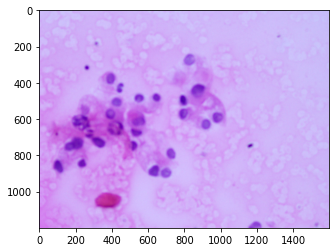

In [ ]:
# Run after click predict in anvil
print(image_received)
plt.imshow(image_received)
plt.savefig('test.png')
print(score)
a = get_label(score)
#print (IMAGE_CLASSES[a[0]])
slice_image(image_received)
print('Size: ',image_received.size)
